In [1]:
import pandas as pd
from vnstock import Vnstock
import datetime
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:


class Stock_data:
    def __init__(self,stock:Vnstock.stock):
        self.stock = stock
        #calculate date
        
        today = datetime.date.today()
        start = today.replace(year=today.year - 5)
        end = today.replace(day=today.day - 1)
        #modify history by adding shift 1 day then remove the first row
        self.history = self.stock.quote.history(start = str(start),end = str(end),interval = "1D")
        self.history["close_shift_1"] = self.history["close"].shift(1)
        self.history = self.history.iloc[1:,:]
    def hpr(self,display_option = False):

        #calculate hpr day
        self.history["hpr"] = (self.history["close"]- self.history["close_shift_1"]) / self.history["close_shift_1"]
        if display_option:
            display(self.history)
    def arithmethic_mean(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        self.a_mean = self.history["hpr"].mean()
        return self.a_mean
    def geometric_mean(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        growth_factors = 1 + self.history["hpr"]
        self.geo_mean = np.prod(growth_factors) ** (1 / len(growth_factors)) - 1
        return self.geo_mean
    def standard_deviation(self,display_option = False):
        if "hpr" not in self.history.columns:
            self.hpr(display_option=display_option)
        self.std_dev = self.history["hpr"].std()  
        return self.std_dev
    def annualize(self):
        if hasattr(self, 'std_dev') and hasattr(self, 'a_mean') and hasattr(self, 'geo_mean'):
            trading_days = 252  # typical number of trading days in a year
            annualized_mean = (1 + self.geo_mean) ** trading_days - 1
            annualized_std = self.std_dev * np.sqrt(trading_days)
            annualized_amean = self.a_mean * trading_days
            return {
                    "Annualized_arithmethic_mean": annualized_amean,
                    "Annualized_geometric_mean": annualized_mean,
                    "Annualized_std": annualized_std,
                    
            }
        else:
            raise AttributeError("Please calculate mean, geometric mean, and standard deviation before annualizing.")



In [3]:
from collections import defaultdict
stocks = ["ACB","VCB","VIC","HPG","FPT"]
results = defaultdict(dict)
for stock in stocks:
    stock_obj = Vnstock().stock(symbol= stock,source="VCI")
    stock_data = Stock_data(stock=stock_obj)
    results["open"] = stock_data.history["open"].copy()
    results["close"] = stock_data.history["close"].copy()
    results["symbol"] = stock



In [4]:
today = datetime.date.today()
start = today.replace(year=today.year - 5)
end = today.replace(day=today.day - 1)
stock_obj = Vnstock().stock(symbol= "ACB",source="VCI")
stock_data = stock_obj.quote.history(start = str(start),end = str(end),interval = "1D")
stock_data

,time,open,high,low,close,volume
0,2020-09-03,7.92,8.03,7.88,7.95,6080561
1,2020-09-04,7.88,7.95,7.80,7.92,4665691
2,2020-09-07,7.92,7.95,7.80,7.80,6067374
3,2020-09-08,7.80,7.84,7.73,7.73,12273484
4,2020-09-09,7.73,7.84,7.62,7.84,5021412
...,...,...,...,...,...,...
1237,2025-08-25,28.20,28.40,25.95,26.20,37410300
1238,2025-08-26,26.25,27.40,26.10,27.35,20812100
1239,2025-08-27,27.80,28.60,27.55,27.65,18831800
1240,2025-08-28,27.80,28.15,27.10,27.55,13927700


In [ ]:
import pandas as pd
from vnstock import Vnstock
import datetime
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
class Portfolio():
    def __init__(self, stocks: list, weight_list: list, start_year_previous=5):
        if len(weight_list) != len(stocks):
            raise ValueError("Length of weight_list must equal length of stocks")
        if np.sum(weight_list) != 1:
            raise ValueError("Sum of weights must equal 1")
        self.stocks = stocks
        self.weight_list = weight_list
        self.history = defaultdict(list)
        today = datetime.date.today()  # 02:16 PM +07, Aug 29, 2025
        start = today.replace(year=today.year - start_year_previous)
        end = today.replace(day=today.day - 1)
        for i, stock in enumerate(self.stocks):
            stock_obj = Vnstock().stock(symbol=stock, source="VCI")
            stock_data = stock_obj.quote.history(start=str(start), end=str(end), interval="1D")
            if stock_data.empty:
                print(f"No data for {stock}")
                continue
            self.history["time"].append(stock_data["time"].copy())
            self.history["open"].append(stock_data["open"].copy())
            self.history["close"].append(stock_data["close"].copy())
            self.history["symbol"].append(stock)
            self.history["weight"].append(weight_list[i])
        
    def calculate_hpr(self, display_option=False):
        self.hpr_df = pd.DataFrame(columns=["stocks", "annualized_return"])
        for i in range(len(self.stocks)):
            data = pd.DataFrame({
                "time": self.history["time"][i],
                "close": self.history["close"][i]
            })
            data["return"] = data["close"].pct_change().dropna()
            if data["return"].empty:
                print(f"No valid returns for {self.stocks[i]}")
                continue
            overall_return = data["return"].mean() * 252  # Annualized return
            self.hpr_df = pd.concat([self.hpr_df, pd.DataFrame({"stocks": [self.stocks[i]], "annualized_return": [overall_return]})], ignore_index=True)
        if display_option:
            print(self.hpr_df)
        return self.hpr_df

    def portfolio_return(self, weights):
        hpr = pd.concat([pd.Series(self.history["close"][i]).pct_change().dropna() for i in range(len(self.stocks))], axis=1)
        if hpr.empty or hpr.isna().all().any():
            print("Warning: Empty or NaN data in returns")
            return 0.0
        hpr.columns = self.stocks
        hpr_annualized = hpr.mean() * 252  # Annualized daily returns
        return np.dot(weights, hpr_annualized)

    def portfolio_variance(self, weights):
        hpr = pd.concat([pd.Series(self.history["close"][i]).pct_change().dropna() for i in range(len(self.stocks))], axis=1)
        if hpr.empty or hpr.isna().all().any():
            print("Warning: Empty or NaN data in returns")
            return 0.0
        hpr.columns = self.stocks
        cov_matrix = hpr.cov() * 252  # Annualize covariance
        if np.any(np.isnan(cov_matrix)):
            print("Warning: NaN in covariance matrix")
            return 0.0
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    def optimize_portfolio(self, target_return):
        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: self.portfolio_return(w) - target_return}
        )
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        initial_guess = np.array(len(self.stocks) * [1. / len(self.stocks)])
        
        result = minimize(self.portfolio_variance, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if result.success:
            return result.fun**0.5, target_return, result.x  # Return volatility, target return, weights
        else:
            print(f"Optimization failed for target_return={target_return}. Message: {result.message}")
            return None
    def draw_efficient_frontier(self,):
        min_return = self.hpr_df["annualized_return"].min()
        max_return = self.hpr_df["annualized_return"].max()
        if pd.isna(min_return) or pd.isna(max_return):
            print("Invalid return range. Check data.")
        else:
            target_returns = np.linspace(min_return, max_return, 50)
            frontier = []
            for tr in target_returns:
                res = self.optimize_portfolio(tr)
                if res:
                    frontier.append(res)

            if frontier:
                volatilities, returns, _ = zip(*frontier)
                plt.figure(figsize=(10, 6))
                plt.plot(volatilities, returns, 'b-', label='Effgiticient Frontier')
                plt.scatter(volatilities, returns, c='blue', s=20)
                plt.xlabel('Volatility (Standard Deviation)')
                plt.ylabel('Expected Return')
                plt.title('Efficient Frontier for Portfolio')
                plt.grid(True)
                plt.legend()
                plt.show()
            else:
                print("No valid points on the efficient frontier. Check data or target returns.")
        # Initialize portfolio
portfolio = Portfolio(stocks=["ACB", "VCB", "VIC"], weight_list=[0.1, 0.3, 0.6], start_year_previous=2)
portfolio.calculate_hpr(display_option=True)
portfolio.draw_efficient_frontier()


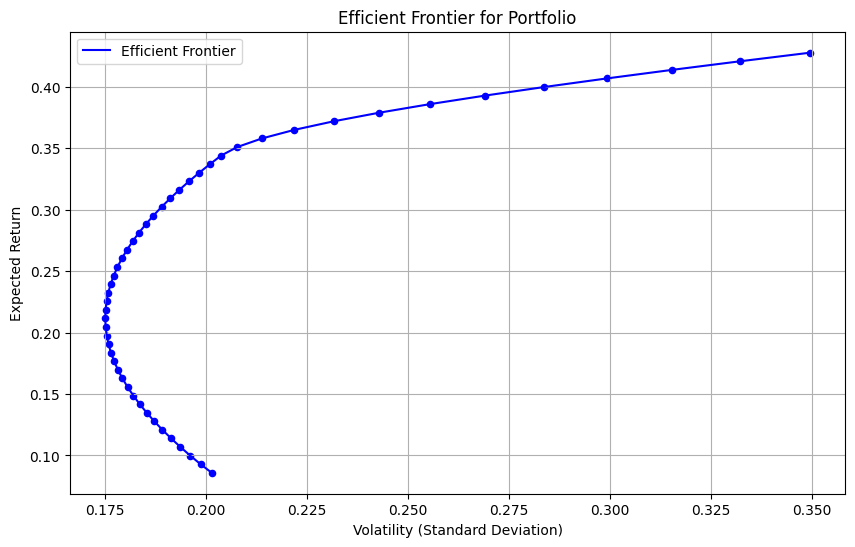

In [6]:
min_return = portfolio.hpr_df["annualized_return"].min()
max_return = portfolio.hpr_df["annualized_return"].max()
if pd.isna(min_return) or pd.isna(max_return):
    print("Invalid return range. Check data.")
else:
    target_returns = np.linspace(min_return, max_return, 50)
    frontier = []
    for tr in target_returns:
        res = portfolio.optimize_portfolio(tr)
        if res:
            frontier.append(res)

    if frontier:
        volatilities, returns, _ = zip(*frontier)
        plt.figure(figsize=(10, 6))
        plt.plot(volatilities, returns, 'b-', label='Efficient Frontier')
        plt.scatter(volatilities, returns, c='blue', s=20)
        plt.xlabel('Volatility (Standard Deviation)')
        plt.ylabel('Expected Return')
        plt.title('Efficient Frontier for Portfolio')
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No valid points on the efficient frontier. Check data or target returns.")

In [7]:
frontier

[(0.20149199126851244,
  0.08595660839095073,
  array([4.13352078e-18, 1.00000000e+00, 3.34035913e-17])),
 (0.19874267971202275,
  0.09293317200453277,
  array([0.03169662, 0.96830338, 0.        ])),
 (0.19618158255811322,
  0.09990973561811481,
  array([0.06339324, 0.93660676, 0.        ])),
 (0.19376511357999016,
  0.10688629923169685,
  array([0.07893912, 0.91066207, 0.01039881])),
 (0.19147749797685423,
  0.11386286284527888,
  array([0.09695633, 0.88383724, 0.01920642])),
 (0.18932218275012544,
  0.12083942645886092,
  array([0.11497355, 0.85701241, 0.02801404])),
 (0.18730373511078696,
  0.12781599007244296,
  array([0.13299076, 0.83018759, 0.03682165])),
 (0.18542662473452654,
  0.134792553686025,
  array([0.15100797, 0.80336276, 0.04562927])),
 (0.18369518442922347,
  0.14176911729960703,
  array([0.16902518, 0.77653793, 0.05443688])),
 (0.18211356915436866,
  0.14874568091318907,
  array([0.18704239, 0.74971311, 0.0632445 ])),
 (0.18068571337646247,
  0.15572224452677108,
  ar

In [8]:
portfolio = Portfolio(stocks=["ACB","VCB","VIC"],weight_list=[0.1,0.3,0.6],start_year_previous=10)
portfolio.calculate_hpr()


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,stocks,annualized_return
0,ACB,0.269869
1,VCB,0.208576
2,VIC,0.223325


In [9]:
annualized_return = pd.concat(portfolio.calculate_hpr()["annualized_return"].to_list(),axis=1)
annualized_return.columns = portfolio.stocks
display(annualized_return)
for i in np.linspace(np.min(annualized_return),np.max(annualized_return),100):
    print(i)
    print(portfolio.optimize_portfolio(i))

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


TypeError: cannot concatenate object of type '<class 'float'>'; only Series and DataFrame objs are valid